## BẢNG PHÂN CÔNG
| MSSV     | Họ và tên        | % đóng góp (tối đa 100%) | Chi tiết công việc |
|----------|------------------|--------------------------|--------------------|
| 19120511 | Võ Văn Hiếu      | 100                      | HTML               |
| 19120526 | Huỳnh Đức Huy    | 100                      | HTML               |
| 19120539 | Vương Thế Khang  | 100                      | API                |
| 19120554 | Lê Kiệt          | 100                      | API                |
| 19120586 | Nguyễn Phát Minh | 100                      | API                |

## Import thư viện cho phân tích HTML và phân tích API

In [1]:
import time                                          
import asyncio                                      
import nest_asyncio                                  
from pyppeteer.errors import TimeoutError, PageError 
from requests_html import AsyncHTMLSession           
from bs4 import BeautifulSoup                        
import pandas as pd             
import requests
import json 
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.chrome.options import Options
import re
import concurrent.futures
import matplotlib.pyplot as plt
from datetime import datetime as dt

nest_asyncio.apply()

# <b><font color=red>A. PARSE HTML

## Ý tưởng
- B1: Bắt đầu từ một danh sách các từ khóa `keywords`, lần lượt tìm và lấy một số thông tin thông tin của một vài playlist ứng với từng từ khóa `keyword`, sử dụng URL https://soundcloud.com/search/sets?q={keyword}.
- B2: Với mỗi playlist tìm được, tìm và lấy một số thông tin của tối đa 5 track trong playlist đó, đồng thời bổ sung thông tin còn sót của playlist tương ứng.
- B3: Với mỗi track tìm được, tìm và lấy thông tin của user chủ của track đó, đồng thời bổ sung thông tin còn sót của track tương ứng.
- B4: Xuất dữ liệu ra các file tương ứng.

## Playlist
Thông tin của một **playlist**:

| Trường            | Mô tả                                                                   |
| ---               | ---                                                                     |
| `id`              | ID của playlist (một số playlist không lấy được ID do mã nhúng được ẩn) |
| `title`           | tiêu đề playlist                                                        |
| `create_date`     | ngày tạo playlist                                                       |
| `likes_count`     | số lượng like của playlist                                              |
| `reposts_count`   | số lượng repost của playlist                                            |
| `tracks_count`    | số lượng track trong playlist                                           |
| `total_playtime`  | tổng thời gian của playlist                                             |
| `tags`            | các tag của playlist                                                    |
| `url`             | URL của playlist                                                        |

## Track
Thông tin của một **track**:

| Trường            | Mô tả                                                                   |
| ---               | ---                                                                     |
| `id`              | ID của track (một số track không lấy được ID do mã nhúng được ẩn)       |
| `title`           | tiêu đề track                                                           |
| `upload_date`     | ngày đăng track                                                         |
| `plays_count`     | số lượt play của track                                                  |
| `likes_count`     | số lượng like của track                                                 |
| `reposts_count`   | số lượng repost của track                                               |
| `comments_count`  | số lượng bình luận của track                                            |
| `tags`            | các tag của track                                                       |
| `url`             | URL của track                                                           |

## User
Thông tin của một **user**:

| Trường            | Mô tả                                                                   |
| ---               | ---                                                                     |
| `display_name`    | tên hiển thị của user                                                   |
| `followers_count` | số lượng người theo dõi user                                            |
| `tracks_count`    | số lượng track của user                                                 |
| `url`             | URL của user                                                            |


## Cách lấy ID của một playlist/track
- B1: Lấy mã nhúng của playlist/track: Trong trang của playlist/track, chọn Share -> Embed (nếu không có thẻ Embed tức là playlist đó ở chế độ riêng tư, không lấy được mã nhúng)

![obtain_embed_code_1](./images/i_1_1.png)
![obtain_embed_code_2](./images/i_1_2.png)
![obtain_embed_code_3](./images/i_1_3.png)

- B2: Lấy ID từ mã nhúng

![obtain_embed_code_4](./images/i_1_4.png)

In [24]:
# Extract ID from playlist embed code
# Return empty string if input embed code is empty
def get_id_from_playlist_embed_code(embed_code):
    if embed_code == '':
        return ''
    
    src = BeautifulSoup(embed_code).find('iframe')['src']
    return src[src.find('api.soundcloud.com/playlists/') + len('api.soundcloud.com/playlists/') : src.find('&')]

# Extract ID from playlist embed code
# Return empty string if input embed code is empty
def get_id_from_track_embed_code(embed_code):
    if embed_code == '':
        return ''
    
    src = BeautifulSoup(embed_code).find('iframe')['src']
    return src[src.find('api.soundcloud.com/tracks/') + len('api.soundcloud.com/tracks/') : src.find('&')]

## Hàm lấy playlists

- `search_playlists_by_keyword(keyword)`: Tìm một vài playlists theo một từ khóa.
 - Input: 
   - `keyword`: từ khóa.
 - Output: một list các playlists tìm được.
 
- `search_playlists_by_keywords(keywords)`: Tìm các playlists theo các từ khóa.
 - Input: 
    - `keywords`: list các từ khóa.
 - Output: một list các playlists tìm được.
 - Hàm chia `keywords` thành nhiều nhóm nhỏ gồm tối đa 10 từ khóa. Sử dụng bất đồng bộ, gọi `search_playlists_by_keyword` lên từng nhóm nhỏ.

In [25]:
# Obtains a list of playlists searched by using a keyword
async def search_playlists_by_keyword(keyword):
    # Empty list contains final result
    _playlists = []
    while True:
        try:
            # Create session
            asession = AsyncHTMLSession()
            
            # Get
            r = await asession.get(f'https://soundcloud.com/search/sets?q={keyword}')
            await r.html.arender(sleep=2, wait=5, scrolldown=30, timeout=250)
            html = r.html.html
            
            # Close session
            try:
                await asession.close()

            except IOError as e:
                pass
               
            # Get playlist items
            search_items = BeautifulSoup(html).find_all('li', class_='searchList__item')
            for search_item in search_items:
                # Title
                title = ''
                _title = search_item.find('a', class_='sc-link-primary soundTitle__title sc-link-dark sc-text-h4')
                if _title is not None:
                    _title = _title.find('span')
                    if _title is not None:
                        title = _title.text
                
                # URL
                url = ''
                _ref = search_item.find('a', class_='sound__coverArt')
                if _ref is not None:
                    url = 'https://soundcloud.com' + _ref['href']
                
                # Add to result if URL isn't already in result
                if url not in [p['url'] for p in _playlists] and url != '':
                    _playlists.append({'id':'', 'title':title, 'create_date':'', 'likes_count':'', 'reposts_count':'', 'tracks_count':'', 'total_playtime':'', 'tags':'', 'url':url})
            
            break
            
        except (TimeoutError, PageError) as e:
            print('Timeout, retrying...')
            await asession.close()
            time.sleep(1)
            continue
    
    print('Keyword:', keyword)
    print(len(_playlists), 'playlist(s)\n')
    return _playlists
            
# Obtains a list of playlists searched by using a list of keywords
async def search_playlists_by_keywords(keywords):
    # Begin benchmark
    print('Start - Retrieving playlists\n')
    start_time = time.time()
    
    # Empty list contains final result
    playlists = []
    
    # Divide keywords into groups of 10
    group_size = 10
    for keyword_group in [keywords[i : i + group_size] for i in range(0, len(keywords), group_size)]:
        # Create tasks to handle each keywords in a group
        rs = [asyncio.create_task(search_playlists_by_keyword(keyword)) for keyword in keyword_group]
        await asyncio.wait(rs)
        
        # Get task results and add to final result
        for r in rs:
            playlists += [d for d in r.result() if d['url'] not in [p['url'] for p in playlists]]  
         
    # End benchmark
    print('Execution time - Retrieving playlists: %s seconds.\n' % (time.time() - start_time))
    return playlists

## Hàm lấy tracks

- `get_tracks_from_playlist(playlists, index)`: Tìm một vài tracks trong một playlist. Mặc định lấy tối đa 5 tracks trên một playlist. Tùy chỉnh bằng cách sửa `tracks_per_playlist` trong cell dưới.
 - Input : 
   - `playlists`: list lưu các playlists tìm được.
   - `index`: chỉ số của playlist đang xét.
 - Output: một list các tracks tìm được, đồng thời cập nhật các thông tin như ID, ngày tạo, số lượng tracks, tổng thời gian, số lượng likes, reposts và các tags của playlist tương ứng.
 
- `get_tracks_from_playlists(playlists)`: Tìm các tracks trong các playlists.
 - Input : 
    - `playlists`: list các playlists.
 - Output: một list các tracks tìm được, đồng thời cập nhật các playlists.
 - Hàm chia `playlists` thành nhiều nhóm nhỏ gồm tối đa 20 playlists. Sử dụng bất đồng bộ, gọi `get_tracks_from_playlist` lên từng nhóm nhỏ.

In [4]:
# Max tracks obtains per playlist
tracks_per_playlist = 5

# Obtains a list of tracks inside a playlist
# Update info about that playlist
async def get_tracks_from_playlist(playlists, index):
    # Empty list contains final result
    _tracks = []
    
    while True:
        try:
            # Create session
            asession = AsyncHTMLSession()
            
            # Get
            r = await asession.get(playlists[index]['url'])
            await r.html.arender(sleep=2, wait=5, scrolldown=50, timeout=250, keep_page=True)
            html = r.html.html
            
            valid_embed_code = '(private)'
            embed_code = ''
            try:
                await r.html.page.evaluate('''() => { 
                    var share_button = document.getElementsByClassName("sc-button-share sc-button-secondary sc-button-secondary sc-button sc-button-medium sc-button-responsive")[0];
                    share_button.click();
                }''')
                time.sleep(1)
     
                await r.html.page.evaluate('''() => {
                    var xpath = "//a[contains(text(),'Embed')]";
                    var embed_tab = document.evaluate(xpath, document, null, XPathResult.FIRST_ORDERED_NODE_TYPE, null).singleNodeValue;
                    embed_tab.click();
                }''')
                time.sleep(1)
                
                embed_code = await r.html.page.evaluate('''() => { 
                    var embed_code = document.getElementsByClassName("widgetCustomization__textInput widgetCustomization__widgetCode")[0];
                    return embed_code.value;
                }''')
                
                valid_embed_code = ''
            except Exception:
                pass
            
            # Close session
            try:
                await asession.close()
                
            except IOError as e:
                pass

            parse = BeautifulSoup(html)
            
            # Create date
            create_date = ''
            _create_date = parse.find('time', class_='relativeTime')
            if _create_date is not None:
                create_date = _create_date['title']
            
            # Summary: tracks count, total playtime
            tracks_count   = ''
            total_playtime = ''
            summary = parse.find('div', class_='fullHero__tracksSummary')
            if summary is not None:
                _tracks_count = summary.find('div', class_='genericTrackCount__title')
                if _tracks_count is not None:
                    tracks_count   = _tracks_count.text.replace(',', '')
                _total_playtime = summary.find('div', class_='genericTrackCount__duration')
                if _total_playtime is not None:
                    total_playtime = _total_playtime.text
            
            # Tags
            tags = ''
            _tags = parse.find_all('span', class_='sc-truncate sc-tagContent')
            if len(_tags) > 0:
                tags = ', '.join([t.text for t in _tags])
            
            # Playlist stats: likes, reposts
            likes_count   = '0'
            reposts_count = '0'
            stats_area = parse.find('ul', attrs={'aria-label':'Playlist stats'})
            if stats_area is not None:
                stats = stats_area.find_all('li', class_='sc-ministats-item')
                for stat in stats:
                    if 'like' in stat['title']:
                        likes_count = stat['title'].rstrip('s').rstrip(' like').replace(',', '')
                    elif 'repost' in stat['title']:
                        reposts_count = stat['title'].rstrip('s').rstrip(' repost').replace(',', '')
            
            # Update playlist
            playlists[index]['id']             = get_id_from_playlist_embed_code(embed_code)
            playlists[index]['create_date']    = create_date
            playlists[index]['tracks_count']   = tracks_count
            playlists[index]['total_playtime'] = total_playtime
            playlists[index]['likes_count']    = likes_count
            playlists[index]['reposts_count']  = reposts_count
            playlists[index]['tags']           = tags
            
            # Get track items
            track_items = parse.find_all('div', class_='trackItem__content sc-truncate', limit=tracks_per_playlist)
            for track_item in track_items:
                
                # Skip geoblocked track items
                track_item_additional = track_item.find_next_sibling('div', class_='trackItem__additional')
                if track_item_additional is not None:
                    if track_item_additional.find('span', class_='trackItem__blockMsg g-geoblocked-icon') is not None:
                        continue

                title_url = track_item.find('a', class_='trackItem__trackTitle sc-link-dark sc-link-primary sc-font-light')

                track_title = ''
                track_url   = ''
                if title_url is not None:
                    track_title = title_url.text
                    track_href  = title_url['href']
                    i = track_href.find('?')
                    if i != -1:
                        track_href = track_href[0:i]
                    track_url = 'https://soundcloud.com' + track_href
                
                # Add to result if URL isn't already in result or invalid
                if track_url not in [track['url'] for track in _tracks] and track_url != '':
                    _tracks.append({'id':'', 'title':track_title, 'upload_date':'', 'plays_count':'', 'likes_count':'', 'reposts_count':'', 'comments_count':'', 'tags':'', 'url':track_url})
            
            break
            
        except (TimeoutError, PageError) as e:
            print('Timeout, retrying...')
            await asession.close()
            time.sleep(1)
            continue
    
    print('Playlist:', playlists[index]['url'], valid_embed_code)
    print(len(_tracks), 'track(s)\n')
    return _tracks

# Obtains a list of tracks from a list of playlists
# Update info about those playlists
async def get_tracks_from_playlists(playlists):
    # Begin benchmark
    print('Start - Retrieving tracks & updating playlists\n')
    start_time = time.time()
    
    # Empty list contains final result
    tracks = []
    
    # Divide playlists into groups of 20
    group_size   = 20
    indices      = [i for i in range(0, len(playlists))]
    index_ranges = [indices[i : i + group_size] for i in range(0, len(indices), group_size)]
    for index_range in index_ranges:
        # Create tasks to handle each playlist in a group
        rs = [asyncio.create_task(get_tracks_from_playlist(playlists, index)) for index in index_range]
        await asyncio.wait(rs)
        
        # Get results and add to final result
        for r in rs:
            tracks += [d for d in r.result() if d['url'] not in [t['url'] for t in tracks]]
           
    # End benchmark
    print('Execution time - Retrieving tracks & updating playlists: %s seconds.\n' % (time.time() - start_time))
    return tracks

## Hàm lấy users

- `get_user_from_track(tracks, index)`: Tìm user chủ của một track.
 - Input : 
   - `tracks`: list lưu các tracks tìm được.
   - `index`: chỉ số của track đang xét.
 - Output: user chủ tìm được, đồng thời cập nhật các thông tin như ID, ngày đăng, số lượng plays, likes, reposts, comments và các tags của track tương ứng.
 
- `get_users_from_tracks(tracks)`: Tìm các users chủ của các tracks.
 - Input : 
    - `tracks`: list các tracks.
 - Output: một list các users tìm được, đồng thời cập nhật các tracks.
 - Hàm chia `tracks` thành nhiều nhóm nhỏ gồm tối đa 20 playlists. Sử dụng bất đồng bộ, gọi `get_user_from_track` lên từng nhóm nhỏ.

In [5]:
# Obtains a list of users from a track
# Update info about that track
async def get_user_from_track(tracks, index):
    while True:
        try:
            # Create session
            asession = AsyncHTMLSession()
            
            # Get
            r = await asession.get(tracks[index]['url'])
            await r.html.arender(sleep=2, wait=5, scrolldown=0, timeout=250, keep_page=True)
            html = r.html.html
            
            valid_embed_code = '(private)'
            embed_code = ''
            try:
                await r.html.page.evaluate('''() => { 
                    var share_button = document.getElementsByClassName("sc-button-share sc-button-secondary sc-button-secondary sc-button sc-button-medium sc-button-responsive")[0];
                    share_button.click();
                }''')
                time.sleep(1)
     
                await r.html.page.evaluate('''() => {
                    var xpath = "//a[contains(text(),'Embed')]";
                    var embed_tab = document.evaluate(xpath, document, null, XPathResult.FIRST_ORDERED_NODE_TYPE, null).singleNodeValue;
                    embed_tab.click();
                }''')
                time.sleep(1)
                
                embed_code = await r.html.page.evaluate('''() => { 
                    var embed_code = document.getElementsByClassName("widgetCustomization__textInput widgetCustomization__widgetCode")[0];
                    return embed_code.value;
                }''')
                
                valid_embed_code = ''
            except Exception:
                pass
            
            # Close session
            try:
                await asession.close()

            except IOError as e:
                pass
            
            parse = BeautifulSoup(html)
            
            # Update date
            upload_date = ''
            _upload_date = parse.find('time', class_='relativeTime')
            upload_date = _upload_date['title']
            
            # Track stats: likes, reposts, plays
            likes_count   = '0'
            reposts_count = '0'
            plays_count   = '0'
            stats_area = parse.find('ul', attrs={'aria-label':'Track stats'})
            if stats_area is not None:
                stats = stats_area.find_all('li', class_='sc-ministats-item')
                for stat in stats:
                    if 'like' in stat['title']:
                        likes_count = stat['title'].rstrip('s').rstrip(' like').replace(',', '')
                    elif 'repost' in stat['title']:
                        reposts_count = stat['title'].rstrip('s').rstrip(' repost').replace(',', '')
                    elif 'play' in stat['title']:
                        plays_count = stat['title'].rstrip('s').rstrip(' play').replace(',', '')
            
            # Comments
            comments_count = '0'
            _comments_count = parse.find('span', class_='commentsList__actualTitle')
            if _comments_count is not None:
                comments_count = _comments_count.text.rstrip('s').rstrip(' comment').replace(',', '')
            
            # Tags
            tags = ''
            _tags = parse.find_all('span', class_='sc-truncate sc-tagContent')
            if len(_tags) > 0:
                tags = ', '.join([t.text for t in _tags])
            
            # Update track
            tracks[index]['id']             = get_id_from_track_embed_code(embed_code)
            tracks[index]['upload_date']    = upload_date
            tracks[index]['likes_count']    = likes_count
            tracks[index]['reposts_count']  = reposts_count
            tracks[index]['plays_count']    = plays_count
            tracks[index]['comments_count'] = comments_count
            tracks[index]['tags']           = tags
            
            # User content: display name, url, followers, tracks count
            user_display_name = ''
            user_url          = ''
            user_content = parse.find('div', class_='userBadge__content sc-media-content')
            if user_content is not None:
                _user_display_name = user_content.find('span')
                if _user_display_name is not None:
                    user_display_name = _user_display_name.text
                _ref = user_content.find('a')
                if _ref is not None:
                    user_url = 'https://soundcloud.com' + _ref['href']

                user_stats = user_content.find_all('li', class_='sc-ministats-item')
                user_followers_count = '0'
                user_tracks_count    = '0'
                for user_stat in user_stats:
                    if 'follower' in user_stat['title']:
                        user_followers_count = user_stat['title'].rstrip('s').rstrip(' follower').replace(',', '')
                    elif 'track' in user_stat['title']:
                        user_tracks_count = user_stat['title'].rstrip('s').rstrip(' track').replace(',', '')
            else:
                print('Fuck')
            
            print('Track:', tracks[index]['url'], valid_embed_code)
            print('User:', user_display_name, '(', user_url, ')\n')
            return {'display_name':user_display_name, 'followers_count':user_followers_count, 'tracks_count':user_tracks_count, 'url':user_url}
        
        except (TimeoutError, PageError) as e:
            print('Timeout, retrying...')
            await asession.close()
            time.sleep(1)
            continue
            
# Obtains a list of users from a list of tracks
# Update info about those tracks
async def get_users_from_tracks(tracks):
    # Begin benchmark
    print('Start - Retrieving users & updating tracks\n')
    start_time = time.time()
    
    # Empty list contains final result
    users = []
    
    # Divide tracks into groups of 20
    group_size   = 20
    indices      = [i for i in range(0, len(tracks))]
    index_ranges = [indices[i : i + group_size] for i in range(0, len(indices), group_size)]
    for index_range in index_ranges:
        # Create tasks to handle each track in a group
        rs = [asyncio.create_task(get_user_from_track(tracks, index)) for index in index_range]
        await asyncio.wait(rs)
        
        # Get results and add to final result
        for r in rs:
            user = r.result()
            if user['url'] not in [u['url'] for u in users] and user['url'] != '':
                users.append(user)
    
    # End benchmark
    print('Execution time - Retrieving users & updating tracks: %s seconds.\n' % (time.time() - start_time))
    return users

## Các từ khóa

In [6]:
keywords = ['Vietnam', 'Lofi'   , 'Chill'      , 'Pop'       , 'Kpop', 
            'Hiphop' , 'Anime'  , 'Future Bass', 'Remix'     , 'EDM', 
            'Trap'   , 'Country', 'Jazz'       , 'Blues'     , 'Trance', 
            'Rap'    , 'Rock'   , 'Acoustic'   , 'Electronic', 'Indie', 
            'Dubstep', 'Folk'   , 'Disney'     , 'Bolero'    , 'Beats',
            'Gaming' , 'Japan'  , 'Ambient'    , 'Piano'     , 'Guitar']

## Gọi các hàm trên, đồng thời đo thời gian thực thi

In [ ]:
start_time = time.time()

playlists = await search_playlists_by_keywords(keywords)
tracks    = await get_tracks_from_playlists(playlists)
users     = await get_users_from_tracks(tracks)

print('Execution time - Total: %s seconds.\n' % (time.time() - start_time))

## Kết quả và xuất file *.csv

In [ ]:
print('Found: ')
print(' - ', len(playlists), 'playlist(s)')
print(' - ', len(tracks), 'track(s)')
print(' - ', len(users), 'user(s)')

df1 = pd.DataFrame(playlists)
df1.to_csv('Crawl_data/playlist.csv', index=False)

df2 = pd.DataFrame(tracks)
df2.to_csv('Crawl_data/track.csv', index=False)

df3 = pd.DataFrame(users)
df3.to_csv('Crawl_data/user.csv', index=False)

## Kiểm tra playlist.csv

In [26]:
df_playlist = pd.read_csv('Crawl_data/playlist.csv')
df_playlist

,id,title,create_date,likes_count,reposts_count,tracks_count,total_playtime,tags,url
0,865751271.0,Lo-Fi Vietnam Chill,10 September 2019,27300,1029,49,2:33:04,"Soundtrack, Soul, Lo-Fi, Acid, Relax, vietnam",https://soundcloud.com/winterhihiihiii/sets/lo...
1,637685136.0,VIETNAM,5 November 2018,13,1,378,26:48:11,NaN,https://soundcloud.com/kim-h-o-525881205/sets/...
2,748126755.0,vietnam,8 April 2019,4,0,377,30:20:28,NaN,https://soundcloud.com/thang-bui-667476417/set...
3,215493136.0,Vietnam,31 July 2020,1,0,289,26:16:14,NaN,https://soundcloud.com/sammmv/sets/vietnam
4,549132048.0,Vietnam,25 November 2019,4,0,271,19:17:59,NaN,https://soundcloud.com/ngan-hoang-810603610/se...
...,...,...,...,...,...,...,...,...,...
1418,579299085.0,guitar,10 August 2018,1,0,93,5:23:23,NaN,https://soundcloud.com/chandler-hughes-5382271...
1419,NaN,Guitar,8 February 2021,0,0,156,8:16:52,NaN,https://soundcloud.com/mose-parentini/sets/guitar
1420,NaN,Guitar,8 February 2021,0,0,156,8:16:52,NaN,https://soundcloud.com/mose-parentini/sets/gui...
1421,135318389.0,Guitar,17 August 2015,3,0,64,5:52:46,NaN,https://soundcloud.com/amr-ats/sets/guitar


## Kiểm tra track.csv

In [27]:
df_track = pd.read_csv('Crawl_data/track.csv')
df_track

,id,title,upload_date,plays_count,likes_count,reposts_count,comments_count,tags,url
0,677922615.0,Đi đâu chẳng thấy - Summer Vee,8 September 2019,2136790,29882,721,1187,Indie,https://soundcloud.com/hueninh2012/di-dau-chan...
1,674121842.0,Ai biết - WEAN,1 September 2019,6518839,58974,1949,916,NaN,https://soundcloud.com/nguyen-pham-phuong-anh-...
2,594037416.0,Nhỏ trên hạnh phúc...,22 March 2019,514811,3798,79,113,Lo-Fi,https://soundcloud.com/chris-hoang-764539027/n...
3,413588520.0,Kina - get you the moon (ft. Snow),14 March 2018,56632462,795341,18111,21955,"Indie, love",https://soundcloud.com/kinabeats/kina-get-you-...
4,432981996.0,First Date (out on spotify),21 April 2018,3491696,49238,1593,1801,"<3, lofi, Hip-hop &Rap, cute, jazz, kawaii, de...",https://soundcloud.com/fradical/first-date
...,...,...,...,...,...,...,...,...,...
5332,260673751.0,Purple Rain - John Petrucci,25 April 2016,16247,279,19,1,Rock,https://soundcloud.com/gbrebner/purple-rain-jo...
5333,344592167.0,Andy James - Gone (Playthrough),29 September 2017,1680,32,1,0,Metal,https://soundcloud.com/askimmdemir/andy-james-...
5334,197779940.0,B.B. King - Lucille,26 March 2015,269137,4986,357,17,"Blues, Lucille, King",https://soundcloud.com/shady-almahmoudi/bb-kin...
5335,202948974.0,Crystal Planet by Joe Satriani,28 April 2015,4902,59,3,0,"Instrumental Rock, joe satriani, crystal plane...",https://soundcloud.com/charlie-munro-mixes/cry...


## Kiểm tra user.csv

In [28]:
df_user = pd.read_csv('Crawl_data/user.csv')
df_user

,display_name,followers_count,tracks_count,url
0,H u ệ N i n h,930,7,https://soundcloud.com/hueninh2012
1,phmnganh,650,4,https://soundcloud.com/nguyen-pham-phuong-anh-...
2,I'ms̶.̶o̶w̶h̶o̶w̶a̶s̶b̶o̶r̶n̶a̶t̶Christ̶m̶a̶s̶,150,9,https://soundcloud.com/chris-hoang-764539027
3,Kina,108529,48,https://soundcloud.com/kinabeats
4,frad,20686,35,https://soundcloud.com/fradical
...,...,...,...,...
3896,Gordon Brebner,9,3,https://soundcloud.com/gbrebner
3897,AŞKIM DEMİR,8,2,https://soundcloud.com/askimmdemir
3898,Shadizm,686,25,https://soundcloud.com/shady-almahmoudi
3899,Charlie Munro Mixes,220,40,https://soundcloud.com/charlie-munro-mixes


# <b><font color=red>B. API

## Khai báo biến toàn cục
Ta sẽ setup biến `sleep_time` toàn cục để quy định số giây mà chương trình sẽ sleep (nhóm quy định là 1 giây). Lí do ta phải setup biến `sleep_time` toàn cục là vì:
- Khi parse HTML, ta cần phải cho chương trình nghỉ giữa các lần thực hiện request để tránh tình trạng "hit" trang web nhiều lần 
- Khi dùng web API, ta sẽ cho chương trình nghỉ nếu như lần request đó thất bại

In [2]:
sleep_time = 1

## Xây dựng hàm lấy `client_id` từ trang soundcloud 
- Hàm này có input là đường dẫn `path` đến file chứa **chromedriver.exe** trong máy thầy, input này có giá trị mặc định là file **chromedriver.exe** (phiên bản 95) trong cùng thư mục code.

- File **chromedriver.exe** là file bắt buộc phải có để cho việc thực thi các hành động lên trình duyệt Chrome một cách tự động thông qua `import selenium`. Mặc định trong đồ án này là <font color=blue>ChromeDriver 95.0.4638.54</font> và có sẵn trong cùng thư mục của file đồ án này, tuy nhiên nó chỉ tương thích với máy có cài trình duyệt Chrome phiên bản 95. Nếu máy thầy không tương thích với phiên bản này, thầy có thể download file **chromedriver.exe** bằng đường link https://chromedriver.chromium.org/downloads tương ứng với phiên bản mà trình duyệt Chrome được cài đặt trong máy.

- <b><u>Nguyên tắc hoạt động</b></u>: hàm ghi lại các hoạt động trong tab Network khi F12 trang web bằng cách cài đặt thuộc tính cho Chrome (set giá trị cho tham số `desired_capabilities` của method Chrome) cho phép nó ghi lại (`get_log`) toàn bộ hoạt động (performance) của người dùng, sau đó lưu các hoạt động vào biến `perf` rồi tìm và trả ra nội dung của chuỗi `client_id`.

In [3]:
# get client id
def get_client_id(path = r'./chromedriver.exe'):
    url = 'https://soundcloud.com/discover'

    # open chrome in headless mode
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    
    caps = DesiredCapabilities.CHROME
    caps['goog:loggingPrefs'] = {'performance': 'ALL'}
    driver = webdriver.Chrome(executable_path=path, desired_capabilities=caps, options=chrome_options)
    driver.get(url)

    # press accept cookies
    cookies_accept = driver.find_element_by_id('onetrust-accept-btn-handler')
    cookies_accept.click()
    time.sleep(5) # wait for all the data to arrive. 

    # record the networking tab
    perf = driver.get_log('performance')

    # get client_id 
    perf = str(perf)
    match = re.search(r'(client_id=\w+&)', perf)
    client_id = match.group(0)[len('client_id='):-1]
    return client_id # string

In [4]:
# TEST
client_id = get_client_id() 
client_id

C:\Users\Admin\AppData\Local\Temp/ipykernel_21072/338873690.py:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=path, desired_capabilities=caps, options=chrome_options)
C:\Users\Admin\AppData\Local\Temp/ipykernel_21072/338873690.py:15: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  cookies_accept = driver.find_element_by_id('onetrust-accept-btn-handler')


'nGKlrpy2IotLQ0QGwBOmIgSFayis6H4e'

## Lấy các chủ đề nhạc từ file "keywords.txt". 
File "keywords.txt" chứa **70 keywords** liên quan tới các thể loại nhạc. Nhóm sẽ đọc hết nội dung file vào list `keywords`. Lý do cần `keywords` là để ở những cell sau, nhóm dùng nó để tạo đường dẫn API lấy các playlist theo từng chủ đề trong `keywords`

In [ ]:
with open('keywords.txt', encoding= 'utf-8') as f:
    keywords = f.readlines()
keywords = [item.strip('\n') for item in keywords]

# TEST
keywords[:5]

## Xây dựng hàm `get_playlist` để thu thập 1 playlist
- Hàm nhận các input là:
    - `keyword`: là chủ đề nhạc đọc từ file ở cell trên, dùng tạo đường dẫn url. Ví dụ: `keyword`='hiphop'
    - `client_id`: là mã client_id của máy thầy, nhận giá trị mặc định là giá `client_id` đã get được ở các cell trên 
    - `limit`: giới hạn kết quả trả về bao nhiêu playlist cho 1 lần tìm kiếm, nhận giá trị mặc định là 50 để lấy khoảng 50 playlist/keyword
<br> <br>
- Hàm thực hiện 2 công việc chính:
    - <font color=orange>Công việc 1</font>: đi tới đường dẫn url có dạng `f'https://api-v2.soundcloud.com/search/playlists?q={keyword}&client_id={client_id}&limit={limit}'` để lấy dữ liệu dạng JSON, convert sang định dạng mà Python có thể lưu được nhờ phương thức <font color=green>json.loads()</font> và lưu vào biến `response`. Tuy nhiên, nhóm chỉ cần lấy toàn bộ playlists nên chỉ cần trỏ tới response['collection'] chứa các playlist và lưu vào `playlist_lists`. Trong quá trình gửi request, khi request không được (`r.ok=False`) thì cho chương trình sleep 1s rồi thực hiện request lại cho tới khi request thành công (`r.ok=True`) 
    - <font color=orange>Công việc 2</font>: Với mỗi playlist trong `playlist_lists` đã lấy ở công việc 1, nhóm lấy các trường sau
        - `id`: mã của playlist đó, mã này dùng để phân biệt với các playlist khác, mỗi playlist sẽ có một mã số `id` duy nhất.
        - `name`: là tên của playlist đó (trong trường hợp playlist đó không có tên thì ta gán `name` là `null`).
        - `genre`: là thể loại của playlist đó (trong trường hợp playlist đó chưa được đặt thể loại thì ta gán `genre` là `null`).
        - `likes_count`: tổng số lượt likes của playlist
        - `track_ids`: là chuỗi gồm danh sách các track có track_id nằm trong playlist đó.
        
        *Có 1 số trường không có giá trị nên sẽ gán giá trị `null`

In [5]:
def get_playlist(keyword, client_id=client_id, limit=50):
    playlists = []
    url = f'https://api-v2.soundcloud.com/search/playlists?q={keyword}&client_id={client_id}&limit={limit}'
    
    # get json data which contains a collection of playlists
    while 1:
        try:
            r = requests.get(url)
        except Exception as e:
            continue
        else:
            if r.ok:
                break
            else:
                time.sleep(sleep_time)
    response = json.loads(r.content)
    playlist_lists = response['collection']

    # get each playlist
    for playlist in playlist_lists: 
        playlist_id = playlist['id']
        playlist_name = 'null' if not playlist['title'] else playlist['title']
        playlist_genre = 'null' if not playlist['genre'] else playlist['genre']
        
        tracks = playlist['tracks']
        track_ids = [track['id'] for track in tracks]
        track_ids = ','.join([str(item) for item in track_ids]) # convert list to string
        
        playlists.append({'id': playlist_id, 
                            'name': playlist_name, 
                            'genre': playlist_genre, 
                            'likes_count': playlist['likes_count'],
                            'track_ids': track_ids})
    return playlists

## Thu thập tất cả playlist
- Vì có rất nhiều url cần phải get cũng như mỗi url có rất nhiều playlist cần parse. Vì vậy nhóm sử dụng kỹ thuật chia luồng để chạy nhằm tăng tốc độ xử lý
- Với mỗi keyword, hàm get_playlist đóng vai trò như 1 luồng, ta sẽ chạy nhiều luồng (tương ứng với nhiều keyword) cùng 1 lúc và lưu kết quả trả về của mỗi luồng (tức kết quả trả về của mỗi hàm là `playlists`) vào list `all_playlists` 

In [ ]:
all_playlists = [] 

with concurrent.futures.ThreadPoolExecutor() as executor:
    playlist_repos = executor.map(get_playlist, keywords)
    for repos in playlist_repos:
        all_playlists += repos

- Loại trùng trong `all_playlists` và xuất ra file `playlist.csv`

In [ ]:
# get rid of duplicates
all_playlists = list({item['id']:item for item in all_playlists}.values())

# export to csv
df_playlists = pd.DataFrame(all_playlists)
df_playlists.to_csv('Api_data/playlist.csv', header= ['playlist_id', 'playlist_name', 'genre', 'likes_count', 'track_ids'], index= False)

- In ra số playlist lấy được

In [ ]:
len(all_playlists)

## Xây dựng hàm `get_track_json` để get dữ liệu dạng JSON cho 1 track
- Hàm nhận input là 
    - `track_id`: mã số của 1 track, sẽ lấy từ thuộc tính danh sách `track_ids` của 1 playlist trong `all_playlists` 
    - `client_id`: giải thích như các hàm trên
- Hàm chỉ đơn giản là request tới url có dạng `f'https://api-v2.soundcloud.com/tracks/{track_id}?client_id={client_id}'` để lấy dữ liệu dạng JSON cho 1 track và trả về `content`. Hàm phục vụ cho hàm `get_track_and_user` phía dưới

In [6]:
def get_track_json(track_id, client_id=client_id):
    track_url = f'https://api-v2.soundcloud.com/tracks/{track_id}?client_id={client_id}'
    while 1:
        try:
            track_response = requests.get(track_url)
        except Exception as e:
            continue
        else:
            if track_response.ok:
                return track_response.content
            else:
                time.sleep(sleep_time)

## Xây dựng hàm `get_track_and_user` để lấy nhiều track và user từ 1 playlist
- Hàm nhận các input là
    - `playlist`: 1 phần tử playlist từ danh sách `all_playlists` đã có ở các cell trên
    - `n_tracks`: số lượng track sẽ lấy của 1 playlist, nhận giá trị mặc định là 15
- Do nhận thấy việc get url cho 15 tracks/playlist khá lâu nên nhóm quyết định chia luồng để chạy, mỗi luồng sẽ **get** và trả về **nội dung** cho 1 track_id nhờ vào hàm `get_track_json` phía trên. Nội dung ấy được lưu vào `track_responses`
- Với từng nội dung trong `track_responses`, nhóm em lấy các thuộc tính sau cho track:
    - `id`: id của track. Lưu ý 1 track có thể nằm trong nhiều playlist
    - `name`: tên track
    - `genre`: thể loại track
    - `playlist_id`: playlist_id mà track có mã là `id` thuộc về
    - `author_id`: mỗi track có 1 user có mã đại diện là `author_id` phụ trách
    - `likes_count`: tổng số lượt likes của track
    - `playback_count`: tổng số lượt replay của track
    - `download_count`: tổng số lượt tải về track đó
<br>
    <b>=> Loại trùng giữa 2 dòng bất kỳ bằng khóa chính (`id`, `playlist_id`)</b>
<br>
<br>
- Vì trong API của track cũng chứa thông tin user phụ trách track đó nên với mỗi user lấy được trong 1 track, các thuộc tính của user gồm:
    - `id`: mã người dùng, là duy nhất. Lưu ý 1 người dùng có thể phụ trách 1 hoặc nhiều track
    - `full_name`: họ và tên user
    - `username`: tên tài khoản user
    - `track_id`: track mà user 
    - `followers_count`: số lượng người theo dõi user đó
<br>
    <b>=> Loại trùng giữa 2 dòng bất kỳ bằng khóa chính (`id`, `track_id`)</b>

In [7]:
# get track & user từ 1 playlist
def get_track_and_user(playlist, n_tracks= 15):
    tracks = []
    users = []
    track_ids = playlist['track_ids']
    
    # precondition: if playlist doesn't have any tracks, then return empty lists 
    if len(track_ids) == 0:
        return tracks, users
    track_ids = track_ids.split(',')[:n_tracks]
    
    # get each track_url's content using threads for faster GET requests
    with concurrent.futures.ThreadPoolExecutor() as executor:	
        track_responses = executor.map(get_track_json, track_ids)
        
    # parse each response
    for res in track_responses:
        # get track info
        track = json.loads(res)
        track_name = 'null' if not track['title'] else track['title']
        track_genre = 'null' if not track['genre'] else track['genre']
        created_date = 'null' if not track['created_at'] else track['created_at']
        
        # get user info
        user = track['user']
        full_name = 'null' if not user['full_name'] else user['full_name']
        username = 'null' if not user['username'] else user['username']
        user_id = user['id']
        
        tracks.append({'id': track['id'], 
                        'name': track_name, 
                        'genre': track_genre,
                        'playlist_id': playlist['id'],
                        'author_id': user_id,           
                        'likes_count': track['likes_count'],
                        'playback_count': track['playback_count'],
                        'download_count': track['download_count'], 
                        'created_date': created_date}) 
        users.append({'id': user_id, 
                        'full_name': full_name,
                        'username': username, 
                        'track_id': track['id'],   
                        'followers_count': user['followers_count']})
    return tracks, users

## Thu thập tất cả track và user
- Do có khoảng 3400 playlist => 3400 * 15 tracks/playlist = ~51000 tracks nên việc chạy 1 luồng sẽ rất lâu, vì vậy nhóm quyết định chạy đa luồng với mỗi luồng là hàm `get_track_and_user` xử lý cho 15 track/playlist (thay vì xử lý 1 luồng duy nhất cho ~51000 tracks/3400 playlist). 
- Kết quả thu về của mỗi luồng gồm res=(`tracks`, `users`) -> lưu vào 2 biến `all_tracks` & `all_users`
- Thời gian ước tính: ~50m

In [ ]:
all_tracks = []    
all_users = [] 

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(get_track_and_user, all_playlists)
    
    for res in results:
        all_tracks += res[0]
        all_users += res[1]

- Loại trùng cho `all_tracks` và `all_users`, rồi xuất ra file `track.csv` và `user.csv`

In [ ]:
# get rid of duplicates based on primary keys
all_tracks = list({(item['id'], item['playlist_id']):item for item in all_tracks}.values())
all_users = list({(item['id'], item['track_id']):item for item in all_users}.values())

# export to csv
df_tracks = pd.DataFrame(all_tracks)
df_users = pd.DataFrame(all_users)

track_header = ['track_id', 'track_name', 'track_genre', 'playlist_id', 'author_id', 'likes_count', 'playback_count', 'download_count', 'created_date'] 
df_tracks.to_csv('Api_data/track.csv', header= track_header, index= False)

user_header = ['user_id', 'full_name', 'username', 'track_id', 'followers_count']
df_users.to_csv('Api_data/user.csv', header= user_header, index= False)

- In ra số tracks và số users lấy được

In [ ]:
print(len(all_tracks), len(all_users))

- Kiểm tra nhanh có tồn tại trùng dòng trong 1 trong 3 file có được

In [8]:
# TEST
file_lst = ['Api_data/playlist.csv', 'Api_data/track.csv', 'Api_data/user.csv']

for fi in file_lst:
    dupl = set()
    no_dupl = []
    
    with open(fi, encoding= 'utf-8') as f:
        for line in f:
            if line in no_dupl:
                dupl.add(line)
            else:
                no_dupl.append(line)
    print(f'{fi}: {len(dupl)}')

Api_data/playlist.csv: 0
Api_data/track.csv: 0
Api_data/user.csv: 0


### ĐỌC DỮ LIỆU TỪ CÁC FILE CSV

In [9]:
df_playlist = pd.read_csv('Api_data/playlist.csv')
df_track = pd.read_csv('Api_data/track.csv')
df_user = pd.read_csv('Api_data/user.csv')

## SỐ MẪU THU THẬP

In [10]:
print(len(df_playlist), len(df_track), len(df_user))

3372 46815 40129


## TRUY VẤN & Ý NGHĨA
Nhóm em làm 1 số truy vấn liên quan tới dữ liệu thu thập để hiểu hơn về dữ liệu 
## I. playlist.csv
### 1. playlist được yêu thích nhiều nhất
Lọc theo trường `likes_count` để lấy ra index của playlist có số lượt thích nhiều nhất. Sau đó dùng hàm `iloc` để truy cập vào playlist đó

In [11]:
max_likes_id = df_playlist['likes_count'].idxmax()
max_likes = df_playlist.iloc[[max_likes_id]]
max_likes

,playlist_id,playlist_name,genre,likes_count,track_ids
3131,460752627,j-hope - Hope World,Hip-hop & Rap,420864,"407002644,407002638,407002635,407002614,407002..."


### 2. playlist có nhiều track nhất
Tạo cột `tracks_count` để đếm số track trong mỗi playlist. Ở cell sau, dựa vào cột này có thể dễ dàng tính được playlist có nhiều track nhất. Thấy rằng:
- Nếu 1 `item` trong `df_playlist['track_ids']` không chứa track_id nào (`item`= NaN) thì `tracks_count` = 0. Mẹo để biết thuộc tính là NaN: 
    <br>**NaN != NaN returns True** <=> item là NaN
- Ngược lại, dùng hàm **split** để đưa chuỗi đó thành dạng list rồi lấy `len` của list đó là ra số track trong 1 playlist

In [12]:
df_playlist['tracks_count'] = [0 if item != item else len(item.split(',')) for item in df_playlist['track_ids']]
df_playlist

,playlist_id,playlist_name,genre,likes_count,track_ids,tracks_count
0,730118454,Best Rap Right Now: Drippin',Hip-hop & Rap,385829,"1134572425,1137390457,1144461559,1150000726,11...",85
1,380154338,Hip Hop Supreme,NaN,178944,"594112890,596212962,593601912,597082389,597563...",27
2,306226961,Lowfi hip hop chills,Lofi Hip Hop,204029,"216774635,406234053,755194606,266707458,670884...",136
3,730129140,Hip-Hop Party Starters: Turn Up,Hip-hop & Rap,104738,"1113703852,1099546222,1122432223,1134572425,10...",51
4,595582668,Study & Chill | Lofi Hiphop,Lofi,95016,"483466125,434763492,473421939,194708585,754271...",21
...,...,...,...,...,...,...
3367,17969127,South East Asia Travel Findings,NaN,0,10764237,1
3368,774255861,South East Asia music,NaN,0,485316636,1
3369,345496216,South East Asia,NaN,0,315565008,1
3370,355570337,South East Asia,NaN,0,315565008,1


Khi có được cột `tracks_count`, truy vấn trở nên đơn giản và tương tự như truy vấn 1 

In [13]:
max_tracks_id = df_playlist['tracks_count'].idxmax()
df_playlist.iloc[[max_tracks_id]]

,playlist_id,playlist_name,genre,likes_count,track_ids,tracks_count
116,674553426,Anime,Anime Music,12,"252481467,180679855,514263150,497645205,345715...",500


## II. track.csv
### 1. Track có nhiều lượt like nhất

In [14]:
max_likes_id = df_track['likes_count'].idxmax()
df_track.iloc[[max_likes_id]]

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,created_date
14286,193781466,Major Lazer & DJ Snake - Lean On (feat. MØ),Major Lazer,665885355,12148579,3055428.0,220969706.0,0.0,2015-03-02T04:31:20Z


### 2. Track có nhiều lượt replay nhất  

In [15]:
max_replay_id = df_track['playback_count'].idxmax()
df_track.iloc[[max_replay_id]]

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,created_date
42609,339318387,XXXTENTACION - Fuck Love (feat. Trippie Redd),Rap/Hip-Hop,360914749,48084634,2942959.0,282419354.0,0.0,2017-08-24T17:04:12Z


## III. user.csv
### 1. Số track mỗi user quản lý

In [16]:
gb = df_user.groupby('user_id')['track_id'].count().sort_values(ascending=False)
gb = pd.DataFrame(gb)
gb

,track_id
user_id,
175766,181
45519877,146
8553751,106
1302868,104
160312592,85
...,...
15944263,1
15926421,1
15923883,1


- Việc sắp xếp giảm dần cho ta thấy rõ user nào tạo bao nhiêu track cũng như user có số track nhiều nhất/ít nhất

### 2. User có nhiều followers nhất

In [17]:
max_follow_id = df_user['followers_count'].idxmax()
df_user.loc[[max_follow_id], ['user_id', 'full_name', 'followers_count']]

,user_id,full_name,followers_count
3196,7436630,Future HNDRXX,9972112


### 3. User nhận về nhiều lượt playback nhất

- Đầu tiên, cần coi mỗi user (hay cũng là `author`) nhận về tất cả bao nhiêu lượt playback -> Sắp xếp giảm dần để thấy được top số playback của mỗi người

In [18]:
author_playback = df_track.groupby('author_id').agg({'playback_count':'sum'}).sort_values(by='playback_count', ascending=False).reset_index()
author_playback = pd.DataFrame(author_playback)
author_playback

,author_id,playback_count
0,12148579,4.896330e+09
1,132790246,4.403016e+09
2,1078461,4.008785e+09
3,10494998,3.713962e+09
4,72181005,3.142993e+09
...,...,...
22153,52739542,0.000000e+00
22154,311523396,0.000000e+00
22155,15987295,0.000000e+00
22156,193633657,0.000000e+00


- Từ kết quả phía trên, thấy rằng user có mã là **'12148579'** có nhiều lượt playback nhất, tiếp tục tìm thông tin user trong file `user.csv`

In [19]:
for i,row in df_user.iterrows():
    if row['user_id'] == author_playback.iloc[[0]]['author_id'][0]:
        break
df_user.iloc[[i], [0,1,2,-1]]

,user_id,full_name,username,followers_count
691,12148579,Major Lazer,Major Lazer,4224746


## THỐNG KÊ DỮ LIỆU

### 1. Thống kê số track được xuất bản từ năm 2007-2021
Để có cái nhìn trực quan hơn về số lượng track được tải lên mỗi ngày, mỗi tháng, mỗi năm, nhóm em quyết định tìm hiểu và thống kê số track được xuất bản từ lúc ra đời của *soundcloud.com* tới hiện tại (2007-2021) dựa theo dữ liệu của track đã được thu thập ở trên.

Hàm `tracks_per_year` nhận giá trị input là dữ liệu `tracks` đã thu thập trước đó và trả về danh sách số lượng track theo từng năm và biểu đồ thể hiện điều đó.

**Các bước thực hiện:**
- Lấy ra ngày xuất bản của từng track dựa vào trường `created_date` vào gán vào list `dt_track`. Ngày xuất bản có định dạng là chuỗi string `%Y-%m-%dT%H:%M:%SZ`. Trường hợp đặc biệt track không có ngày xuất bản thì bỏ qua.
- Tìm năm nhỏ nhất và năm lớn nhất từ biến `dt_track` và đặt nó làm trục x của biểu đồ.
- Đếm số lượng track theo từng năm và đặt nó làm trục y của biểu đồ.
- Đặt tên biểu đồ, cột x, cột y, định dạng biểu đồ.
- Hiển thị biểu đồ ra màn hình.

In [20]:
def tracks_per_year(tracks = df_track):
    dt_track = [dt.strptime(track, '%Y-%m-%dT%H:%M:%SZ') for track in tracks['created_date'] if not track == 'null']
    min_year = min([year.year for year in dt_track])
    max_year = max([year.year for year in dt_track])
    x = list(range(min_year, max_year+1))
    y = []
    for i in x:
        y.append(len([year.year for year in dt_track if year.year == i]))
    plt.bar(x, y, color='blue')
    plt.title('Thống kê số track được xuất bản trong mỗi năm')
    plt.xlabel('Năm')
    plt.ylabel('Track/năm')
    plt.show()
    return {'year': x, 'track': y}

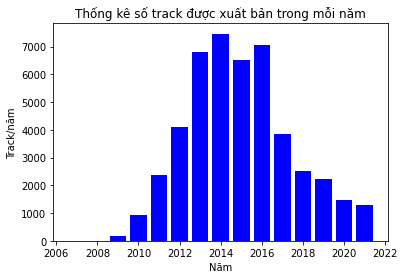

,year,track
0,2007,2
1,2008,9
2,2009,166
3,2010,919
4,2011,2389
5,2012,4100
6,2013,6816
7,2014,7465
8,2015,6524
9,2016,7074


In [21]:
# TEST
result = pd.DataFrame(tracks_per_year(df_track))
result

**Nhận xét:** Các track thường được xuất bản nhiều từ năm 2014-2016 do đây là thời điểm mà soundcloud.com được nhiều người biết tới, so với những năm gần đây (2020, 2021,...), người dùng có xu hướng thay đổi các nền tảng nghe nhạc trực tuyến khác ngoài soundcloud.com nên số track được đăng tải trên đây giảm đi.

### 2. Thống kê số track được xuất bản mỗi tháng trong năm
Cũng tương tự với cách thống kê số track được xuất bản từ năm 2007-2021, hàm `tracks_per_month` nhận giá trị input là dữ liệu `tracks` đã thu thập trước đó và năm `year` mà thầy tự chọn, output trả về danh sách số lượng track theo từng tháng trong năm và biểu đồ thể hiện điều đó.
**Các bước thực hiện:**
- Lấy ra ngày xuất bản của từng track dựa vào trường `created_date` vào gán vào list `dt_track`. Ngày xuất bản có định dạng là chuỗi string `%Y-%m-%dT%H:%M:%SZ`. Trường hợp đặc biệt track không có ngày xuất bản thì bỏ qua.
- Do 1 năm = 12 tháng nên đặt 12 tháng làm trục x của biểu đồ.
- Đếm số lượng track theo từng tháng trong năm `month` và đặt nó làm trục y của biểu đồ.
- Đặt tên biểu đồ, cột x, cột y, định dạng biểu đồ.
- Hiển thị biểu đồ ra màn hình.

In [22]:
def tracks_per_month(tracks = df_track, year = 2019):
    dt_track = [dt.strptime(track, '%Y-%m-%dT%H:%M:%SZ') for track in tracks['created_date'] if not track == 'null']
    x = list(range(1,13))
    y = []
    for i in x:
        y.append(len([month.month for month in dt_track if month.month == i and month.year == year]))
    plt.bar(x, y, color='blue')
    plt.title('Thống kê số track được xuất bản trong năm ' + str(year))
    plt.xlabel('Tháng')
    plt.ylabel('Track/tháng')
    plt.show()
    return {'month': x, 'track': y}

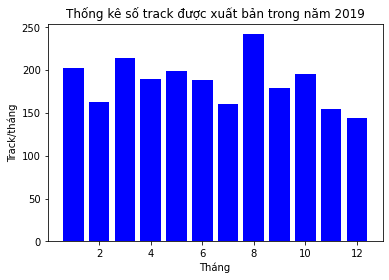

,month,track
0,1,203
1,2,163
2,3,214
3,4,190
4,5,199
5,6,189
6,7,161
7,8,242
8,9,179
9,10,196


In [23]:
# TEST
result = pd.DataFrame(tracks_per_month(df_track, 2019))
result

**Nhận xét:** Các track đa phần đều được xuất bản vào mỗi tháng trong năm. Trong tháng 8/2019 đạt được số track đăng tải cao nhất.